# GROUP 35 - STAT 301 FINAL REPORT

### Group member:
- Doris Che (33996984)
- Eric Kim (87743738)
- Naufal Prasojo (14303440)
- Isaiah Nitin (79496493)


### **2. INTRODUCTION**


We are interested to understand which listing characteristics (e.g `price`, `superhost`, etc) and location-based features (e.g `dist`, `metro_dist`, `attr_index_n`, etc) are most strongly associated with higher or lower Airbnb's `guest_satisfaction` in Athens. Our reponse variable will be `guest_satisfaction`, representing the overall guest satisfaction level of the Airbnb listing in Athens. Our question is focused on inference, as we are investing the association between the response and explanatory variables. We are not using the explanatory variables to predict what the satisfaction rating of an arbitrary listing may be.

#### **3. Methods and Results**

### A) Data

**1.1 Data Summary**
- **Dataset Name:** Airbnb Prices in European Cities
- **Source:** Kaggle dataset by The Devastator (2021). Available at
https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities
- **License:** CC BY-NC 4.0 (Attribution-NonCommercial).
- **Data Collection:** Listings were web-scraped from Airbnb for 10 European cities (Amsterdam, Athens, Barcelona, Berlin, Budapest, Lisbon, London, Paris, Rome, Vienna), but for this assignment we only use Athens data.
     - Each city has two files (weekday and weekend) capturing snapshot prices for 2-night stays for two guests.
     - Approx. 2627~2653 observations (rows) and 19 variables (columns).

**1.2 Source and Information**

The data were collected by web-scraping Airbnb public listings around 2020–2021 by The Devastator. The author compiled cleaned CSV files for each city and time category (weekday vs weekend) and license as CC BY-NC 4.0 (Attribution-NonCommercial).

**1.3 Pre-Selection of Variables**

- Variables to keep: `guest_satisfaction_overall` (as response variable), `realSum`, `superhost`, `cleanliness_rating`, `dist`, `metro_dist`, `attr_index_norm`, `rest_index_norm`.

Reasoning: These variables seem most useful for both understanding factors for Airbnb prices or for building a model that can help estimate fair prices for future listings in Athens.

- Variables to drop (initial cleaning phase):

    - `room_type` - reflects a guest’s functional need rather than overall satisfaction, so it’s not a meaningful explanatory variable for rating differences.
    - `person_capacity` - highly correlated with other size-related features but adds little/none independent information for satisfaction.
    - `weekday/weekend` - categorical timing variable that might not relevant with overall satisfaction.
    - `lng`, `lat` – spatial coordinates does not needed for non-map models (but can be added later for spatial EDA).
    - `attr_index`, `rest_index` – very similar with normalized versions and may introduce redundancy.
    - `multi`, `biz` – may be reintroduced if host type becomes an interest variable, but initial models will focus on inference model for price.
    - `room_shared`, `room_private` – these indicators are redundant with `room_type`, so I will not include.

Reasoning: Variables dropped contain redundant or identifier information not directly useful for predictive or interpretive modelling. All decisions will be re-evaluated after EDA.

----------

### B) Exploratory Data Analysis

In [2]:
# Cleaning data: removing nonsense outliers
"number obeservations for realSum >= 10000: "
nrow(athens_weekdays[athens_weekdays$realSum >= 10000, ])

athens_weekdays_clean <- athens_weekdays %>% filter(realSum < 10000)
summary(athens_weekdays_clean$guest_satisfaction_overall)

athens_weekends_clean <- athens_weekends %>% filter(realSum < 10000)
summary(athens_weekends_clean$guest_satisfaction_overall)

# Combine datasets for comparison plots + add binary period column
athens <- bind_rows(
  athens_weekdays_clean %>% mutate(period = "Weekday"),
  athens_weekends_clean %>% mutate(period = "Weekend")
) %>%
  mutate(period = factor(period, levels = c("Weekday","Weekend")))

head(athens)

[1] "number obeservations for realSum >= 10000: "

[1] 1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   20.0    94.0    97.0    95.1   100.0   100.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.00   93.00   97.00   94.91  100.00  100.00 

,X,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,period
,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,129.82448,Entire home/apt,False,False,4,False,0,0,10,⋯,2,2.8139635,0.8818900,55.34857,2.086871,78.77838,5.915160,23.76600,37.98300,Weekday
2,1,138.96375,Entire home/apt,False,False,4,True,1,0,10,⋯,1,0.4072929,0.3045679,240.30665,9.060559,407.16770,30.572629,23.73168,37.97776,Weekday
3,2,156.30492,Entire home/apt,False,False,3,True,0,1,10,⋯,1,1.2372111,0.2884881,199.50737,7.522257,395.96740,29.731642,23.72200,37.97900,Weekday
4,3,91.62702,Entire home/apt,False,False,4,True,1,0,10,⋯,1,4.3674572,0.2974673,39.80305,1.500740,58.70658,4.408047,23.72712,38.01435,Weekday
5,4,74.05151,Private room,False,True,2,False,0,0,10,⋯,1,2.1941850,0.3852657,78.73340,2.968577,113.32597,8.509204,23.73391,37.99529,Weekday
6,5,113.88934,Entire home/apt,False,False,6,True,1,0,10,⋯,2,2.0712056,0.4538674,96.58899,3.641806,158.64432,11.911981,23.71584,37.98598,Weekday


In [3]:
# Visualizing the distribution of guest_satisfaction_overall for weekdays and weekends

distribution_satisfaction_weekends <- ggplot(athens_weekends_clean, aes(x = guest_satisfaction_overall)) +
    geom_histogram(bins = 30, fill = "orange", color = "white") +
    labs(title = "Distribution of Airbnb Guest Satisfaction in Athens on weekends",
        x = "Guest Satisfaction Overall",
        y = "Count") +
    theme_minimal()

distribution_satisfaction_weekdays <- ggplot(athens_weekdays_clean, aes(x = guest_satisfaction_overall)) +
    geom_histogram(bins = 30, fill = "skyblue", color = "white") +
    labs(title = "Distribution of Airbnb Guest Satisfaction in Athens on weekdays",
        x = "Guest Satisfaction Overall",
        y = "Count") +
    theme_minimal()

distribution_satisfaction_combine <- ggplot(athens, aes(x = guest_satisfaction_overall, fill = period, color = period)) +
  geom_histogram(position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Airbnb Guest Satisfaction in Athens",
        x = "Guest Satisfaction Overall",
        y = "Count") +
  scale_fill_brewer(palette = "Set2") +
  scale_color_brewer(palette = "Set2")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`geom_smooth()` using formula = 'y ~ x'


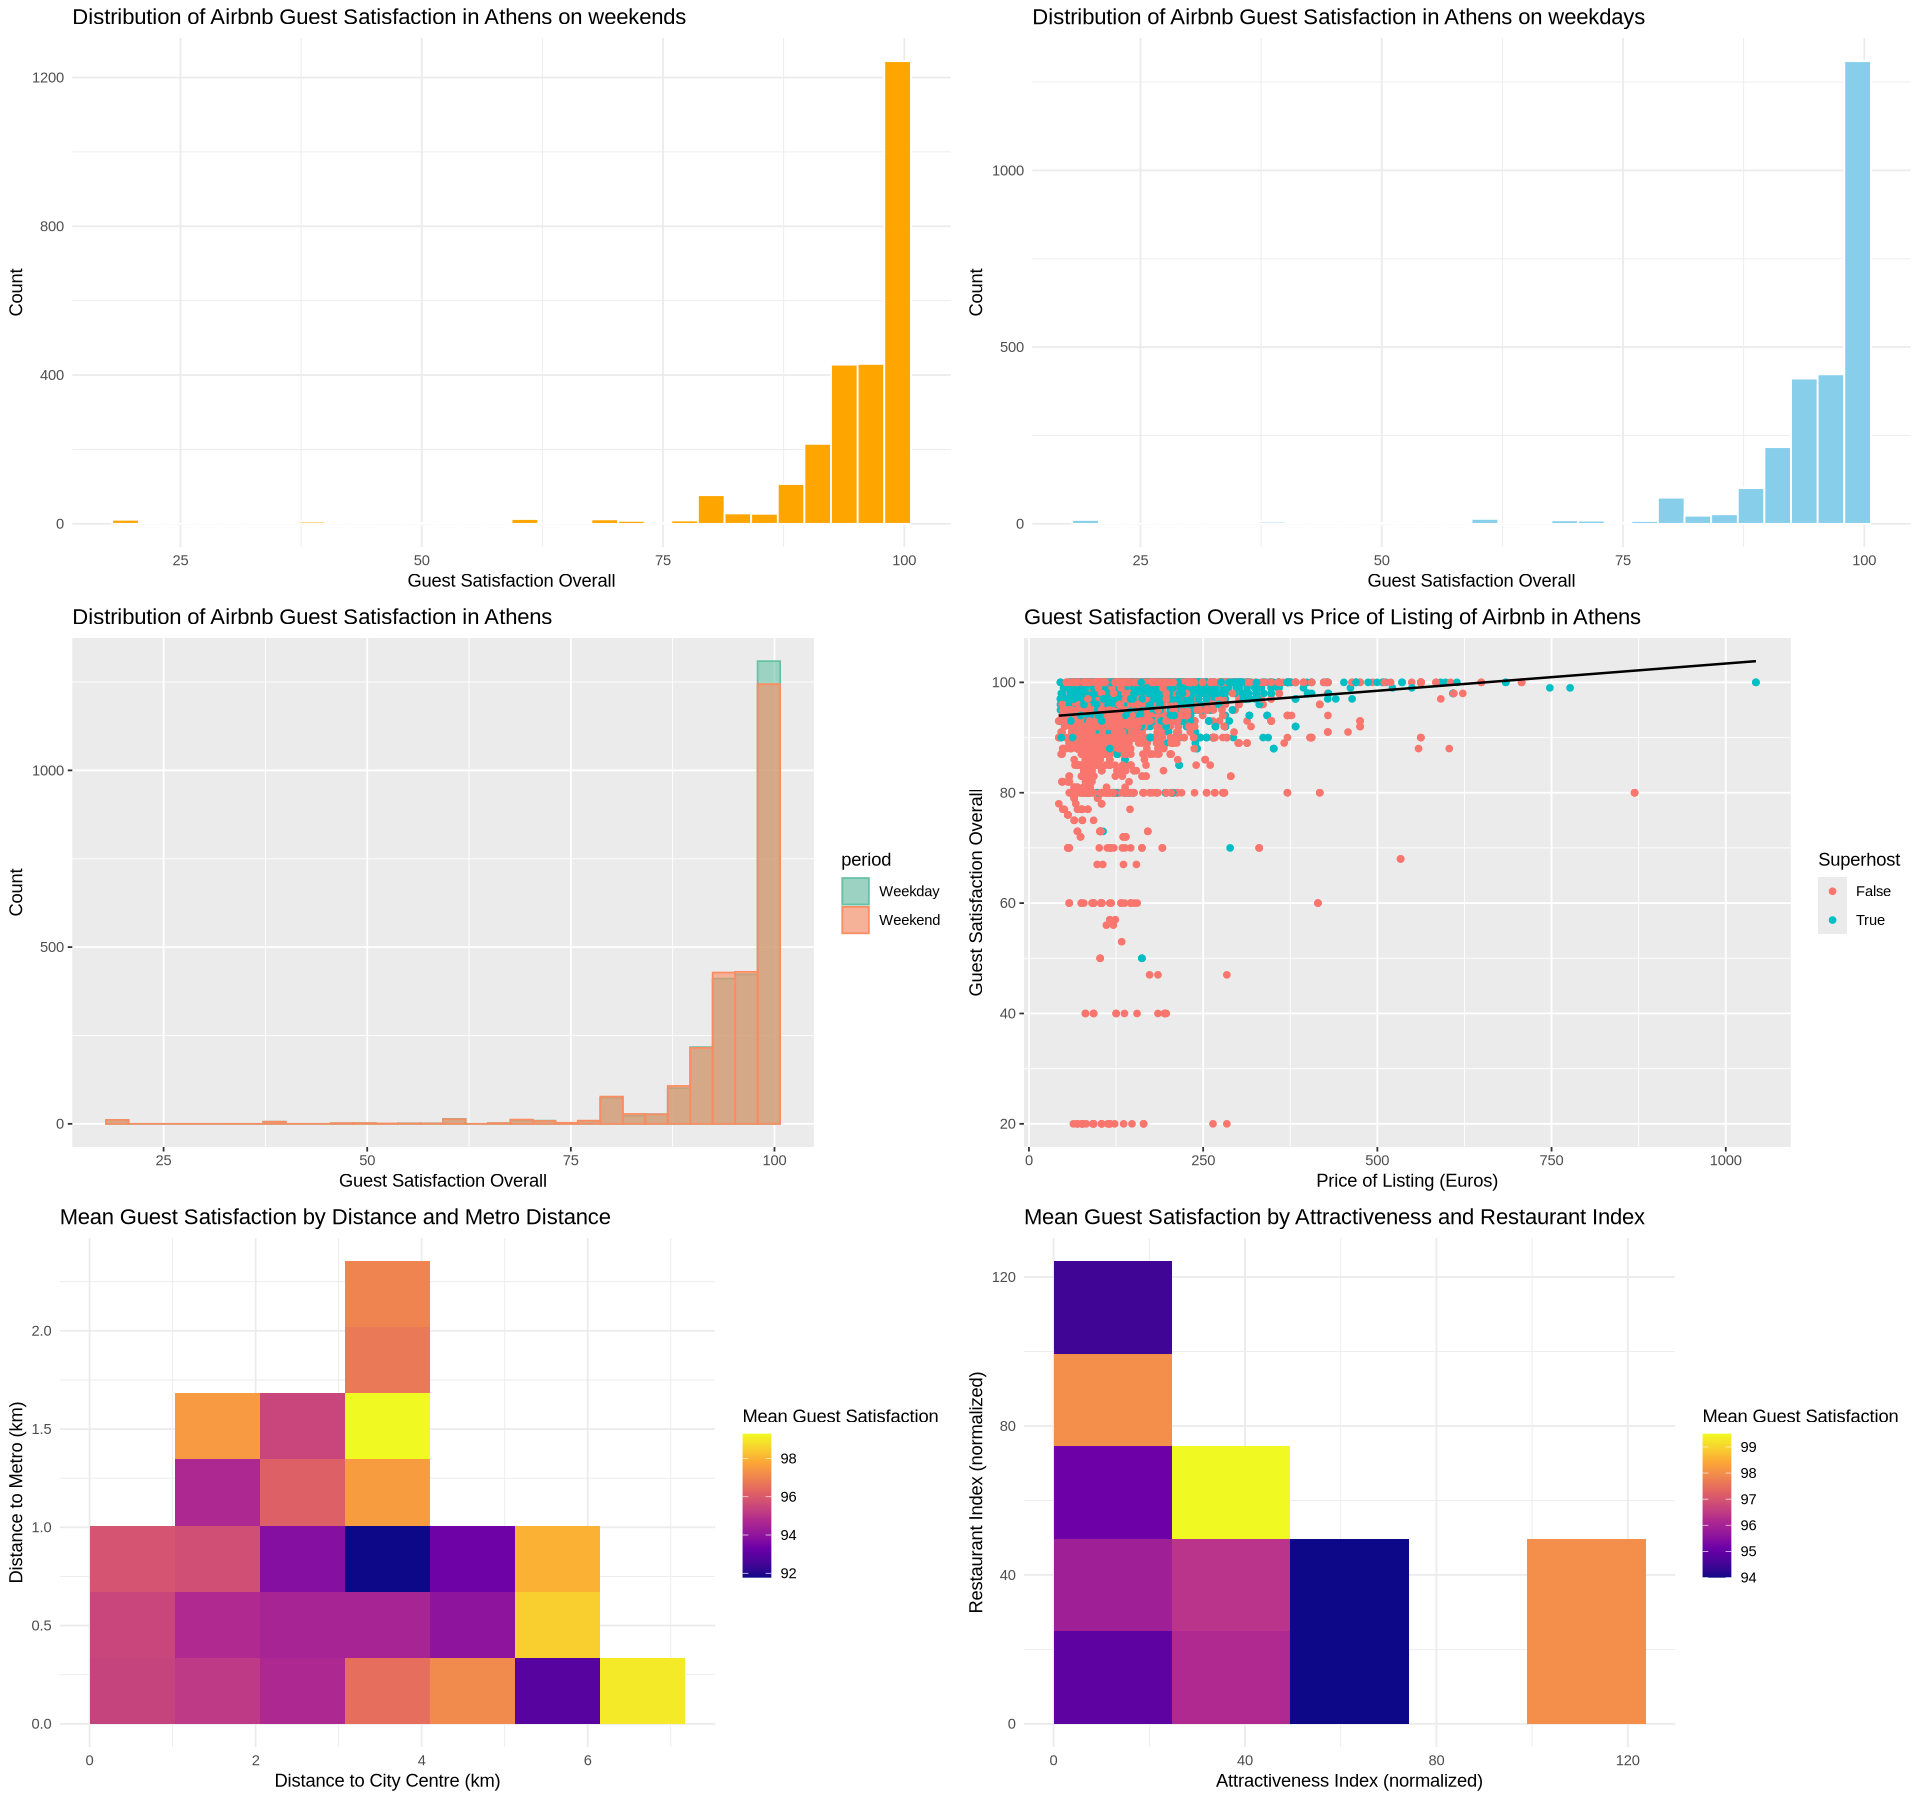

In [4]:
satis_double_dist_plot <- ggplot(athens, aes(x = dist, y = metro_dist, z = guest_satisfaction_overall)) +
  stat_summary_2d(fun = mean, bins = 6) +
  scale_fill_viridis_c(option = "C") +
  labs(title = "Mean Guest Satisfaction by Distance and Metro Distance",
       x = "Distance to City Centre (km)", y = "Distance to Metro (km)",
       fill = "Mean Guest Satisfaction") +
  theme_minimal()

satis_double_index_plot <- ggplot(athens, aes(x = attr_index_norm, y = rest_index_norm, z = guest_satisfaction_overall)) +
  stat_summary_2d(fun = mean, bins = 4) +
  scale_fill_viridis_c(option = "C") +
  labs(title = "Mean Guest Satisfaction by Attractiveness and Restaurant Index",
       x = "Attractiveness Index (normalized)", y = "Restaurant Index (normalized)",
       fill = "Mean Guest Satisfaction") +
  theme_minimal()

athens_combined_plot <- athens |>
    ggplot(aes(x = realSum, y = guest_satisfaction_overall, color = host_is_superhost)) +
           geom_point() +
           geom_smooth(method = "lm", se = FALSE, color = "black", linewidth = 0.7) +
           ggtitle("Guest Satisfaction Overall vs Price of Listing of Airbnb in Athens") +
           xlab("Price of Listing (Euros)") +
           ylab("Guest Satisfaction Overall") +
           labs(color = "Superhost")

options(repr.plot.width = 16, repr.plot.height = 15)
plot_grid(distribution_satisfaction_weekends, distribution_satisfaction_weekdays,
          distribution_satisfaction_combine, athens_combined_plot,
          satis_double_dist_plot, satis_double_index_plot,
          ncol = 2)

### C) Methods: Plan

We will be using three linear models;

1. **Simple Linear Regression** 
    * Model: guest_satisfaction_overall ~ realSum
    * Justification: The SLR baseline model will allow us to establish the association between price and guest satisfaction helping us see if higher prices correlate with guest         satisfaction before accounting for other variables that could change how the guest could feel.
2. **Multiple Linear Regression (Additive Model)**
    * Model: guest_satisfaction_overall ~ realSum + dist + metro_dist + host_is_superhost + attr_index_norm + rest_index_norm
    * Justification: The MLR is an appropriate method to understand and estimate the effect between one explanatory variable and others as constant since guest satisfaction is our response variable. This helps us decide if being a superhost increases guest satisfaction ratings with price and location as constant.
3. **Multiple Linear Regression (Interaction Model)**
    * Model: realSum x host_is_superhost
    * Justification: Using an interaction model is necessary to determine if the relationship between price and guest satisfaction depends if the host is a superhost or a regular host.

**Model Assessment and Diagnostics**

We will assess our methods by using Linear Regression Assumptions
* ***Linearity and Equal Variance*** = Residuals vs Fitted plots will help us understand how random scattered points around zero would indicate linearity and homoscedasticity assumptions are valid.
* ***Multicollinearity*** = We understand the risks of how the variables could be related to each other and hence calculating the variance inflation factor (VIF) would be of significant use.
* ***Comparing Models*** = Adjusted R^2 values to compare the fit of SLR, additive MLR and interaction models so that we do not overcrowd our data with many points.
